In [1]:
import pandas as pd
from cutils import *
from pathlib import Path

In [2]:
train_data = pd.read_csv(Path(data_location, "bank_account_classifier_training_set.csv"))

In [3]:
print(train_data.head())

   labels                              full_bank_description  \
0     401  CB DE SOUSA ANTONI FACT 300720 M BERTHINIER CH...   
1     401  *BERI DETECTISARL 3A SERVICES FR80AAA481533 BE...   
2     401  VIR SEPA DEBIESSE ANNULATION VIRT PAR ERREUR D...   
3     401  CB COTE COMPTOIR FACT 160920 M BERTHINIER CHAR...   
4     401     FACTURE N 034 VERS 12135 00300 04365870673 39    

            DB_NAME  bankAccountBankName  bankAccountBranch  bankAmount  \
0  YPN_DB1000232254              13825.0              200.0       -4.35   
1  YPN_DB1000232254              13825.0              200.0      -78.00   
2  YPN_DB1000232254              13825.0              200.0       72.00   
3  YPN_DB1000232254              13825.0              200.0      -12.00   
4  YPN_DB1000232254              13825.0              200.0      -60.00   

   lettering_code  payment_day  payment_month  payment_year  
0               0            1              8          2020  
1               0           10          

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
numerical_x = train_data[["bankAccountBankName", "bankAccountBranch", "bankAmount", "lettering_code", "payment_day", "payment_month", "payment_year"]]
numerical_x.head()

,bankAccountBankName,bankAccountBranch,bankAmount,lettering_code,payment_day,payment_month,payment_year
0,13825.0,200.0,-4.35,0,1,8,2020
1,13825.0,200.0,-78.00,0,10,9,2020
2,13825.0,200.0,72.00,0,5,12,2019
3,13825.0,200.0,-12.00,0,17,9,2020
4,13825.0,200.0,-60.00,1,28,1,2021


In [6]:
labels = train_data[["labels"]]
labels.head()

,labels
0,401
1,401
2,401
3,401
4,401


In [7]:
cor = train_data[["labels", "bankAccountBankName", "bankAccountBranch", "bankAmount", "lettering_code", "payment_day", "payment_month", "payment_year"]]
cor.head()

,labels,bankAccountBankName,bankAccountBranch,bankAmount,lettering_code,payment_day,payment_month,payment_year
0,401,13825.0,200.0,-4.35,0,1,8,2020
1,401,13825.0,200.0,-78.00,0,10,9,2020
2,401,13825.0,200.0,72.00,0,5,12,2019
3,401,13825.0,200.0,-12.00,0,17,9,2020
4,401,13825.0,200.0,-60.00,1,28,1,2021


In [8]:
corr_mat = cor.corr()

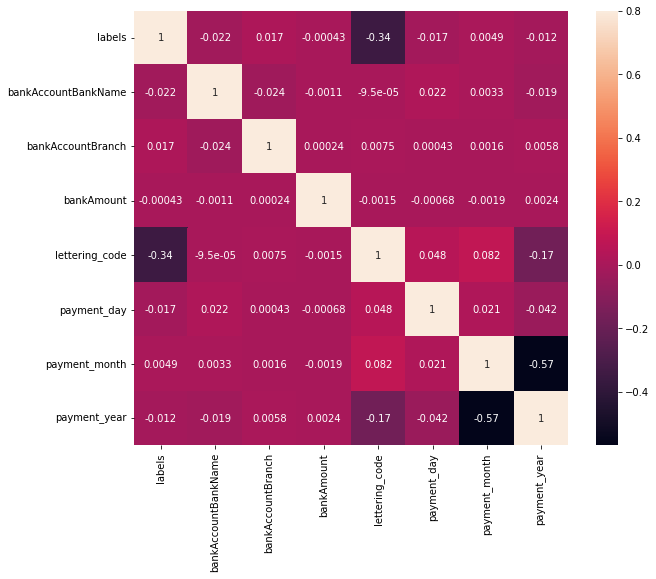

In [9]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_mat, annot=True, vmax=.8, square=True, ax=ax)
plt.show()

In [10]:
corr_mat

,labels,bankAccountBankName,bankAccountBranch,bankAmount,lettering_code,payment_day,payment_month,payment_year
labels,1.000000,-0.022478,0.016969,-0.000432,-0.344987,-0.017295,0.004889,-0.011560
bankAccountBankName,-0.022478,1.000000,-0.023606,-0.001146,-0.000095,0.022353,0.003329,-0.018777
bankAccountBranch,0.016969,-0.023606,1.000000,0.000241,0.007514,0.000427,0.001601,0.005824
bankAmount,-0.000432,-0.001146,0.000241,1.000000,-0.001504,-0.000684,-0.001930,0.002414
lettering_code,-0.344987,-0.000095,0.007514,-0.001504,1.000000,0.048278,0.082265,-0.171030
payment_day,-0.017295,0.022353,0.000427,-0.000684,0.048278,1.000000,0.020616,-0.041647
payment_month,0.004889,0.003329,0.001601,-0.001930,0.082265,0.020616,1.000000,-0.569010
payment_year,-0.011560,-0.018777,0.005824,0.002414,-0.171030,-0.041647,-0.569010,1.000000


In [11]:
from sklearn.preprocessing import LabelEncoder

In [12]:
train_data = pd.read_csv(Path(data_location, "bank_account_classifier_training_set.csv"))
label_encoder = LabelEncoder()
label_encoder.fit(train_data["labels"])

print(len(label_encoder.classes_))

124


In [13]:
train_data = pd.read_csv(Path(data_location, "bank_account_classifier_test_set.csv"))
label_encodert = LabelEncoder()
label_encodert.fit(train_data["labels"])
print(len(label_encodert.classes_))

58


In [14]:
print(len(set(label_encoder.classes_).intersection(set(label_encodert.classes_))))

58


In [16]:
from evaluate import metric, test_roberta
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [18]:
results = []
for i in range(10):
    print("Fold {}:".format(i+1))
    t = AutoTokenizer.from_pretrained(Path(data_location, "bank-classifier-roberta-fold-{}".format(i+1)))
    m = AutoModelForSequenceClassification.from_pretrained(Path(data_location, "bank-classifier-roberta-fold-{}".format(i+1)), num_labels=num_classes)
    a, l, mi, ma = test_roberta(m, t)

    results.append({"fold": i+1, "micro": mi*100, "macro": ma * 100, "loss": l, "accuracy": a * 100})

df = pd.DataFrame(results)
df['micro'] = df['micro'].apply(lambda x: round(x, 2))
df['macro'] = df['macro'].apply(lambda x: round(x, 2))
df['accuracy'] = df['accuracy'].apply(lambda x: round(x, 2))

df.sort_values(by=["macro", "accuracy"], inplace=True)

df.to_csv(Path(data_location, "test_accuracy.csv"), index=False)

print("best folds - ")
print(df[["fold", "macro", "accuracy", "loss"]])

Fold 1:


Using custom data configuration default-ccef78690732dd47
Reusing dataset csv (/home/sadid/.cache/huggingface/datasets/csv/default-ccef78690732dd47/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/sadid/.cache/huggingface/datasets/csv/default-ccef78690732dd47/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a/cache-6ad268650a0fd06d.arrow
100%|█████████▉| 2813/2820 [00:38<00:00, 74.29it/s]/mnt/Cache/PycharmProjects/bank-account-classifier/evaluate.py:24: RuntimeWarning: invalid value encountered in long_scalars
  p = (tp / (tp + fp))
100%|██████████| 2820/2820 [00:38<00:00, 73.25it/s]


	micro accuracy: 0.737322695035461
	macro accuracy: 0.9454079246510911
Fold 2:


Using custom data configuration default-ccef78690732dd47
Reusing dataset csv (/home/sadid/.cache/huggingface/datasets/csv/default-ccef78690732dd47/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/sadid/.cache/huggingface/datasets/csv/default-ccef78690732dd47/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a/cache-ca224210387b3122.arrow
100%|█████████▉| 2819/2820 [00:37<00:00, 73.90it/s]/mnt/Cache/PycharmProjects/bank-account-classifier/evaluate.py:24: RuntimeWarning: invalid value encountered in long_scalars
  p = (tp / (tp + fp))
100%|██████████| 2820/2820 [00:38<00:00, 74.13it/s]


	micro accuracy: 0.7391400709219859
	macro accuracy: 0.9526828069432206
Fold 3:


Using custom data configuration default-ccef78690732dd47
Reusing dataset csv (/home/sadid/.cache/huggingface/datasets/csv/default-ccef78690732dd47/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/sadid/.cache/huggingface/datasets/csv/default-ccef78690732dd47/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a/cache-ce6d36bf9bc29c66.arrow
100%|█████████▉| 2813/2820 [00:37<00:00, 74.70it/s]/mnt/Cache/PycharmProjects/bank-account-classifier/evaluate.py:24: RuntimeWarning: invalid value encountered in long_scalars
  p = (tp / (tp + fp))
100%|██████████| 2820/2820 [00:37<00:00, 74.43it/s]


	micro accuracy: 0.7416223404255319
	macro accuracy: 0.9529084437274675
Fold 4:


Using custom data configuration default-ccef78690732dd47
Reusing dataset csv (/home/sadid/.cache/huggingface/datasets/csv/default-ccef78690732dd47/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/sadid/.cache/huggingface/datasets/csv/default-ccef78690732dd47/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a/cache-1faf15b20e6503dd.arrow
100%|██████████| 2820/2820 [00:37<00:00, 74.98it/s]/mnt/Cache/PycharmProjects/bank-account-classifier/evaluate.py:24: RuntimeWarning: invalid value encountered in long_scalars
  p = (tp / (tp + fp))
100%|██████████| 2820/2820 [00:37<00:00, 74.25it/s]


	micro accuracy: 0.7445921985815603
	macro accuracy: 0.9452174413672454
Fold 5:


Using custom data configuration default-ccef78690732dd47
Reusing dataset csv (/home/sadid/.cache/huggingface/datasets/csv/default-ccef78690732dd47/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/sadid/.cache/huggingface/datasets/csv/default-ccef78690732dd47/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a/cache-f17e513bfa490f60.arrow
100%|█████████▉| 2818/2820 [00:38<00:00, 72.77it/s]/mnt/Cache/PycharmProjects/bank-account-classifier/evaluate.py:24: RuntimeWarning: invalid value encountered in long_scalars
  p = (tp / (tp + fp))
100%|██████████| 2820/2820 [00:38<00:00, 73.93it/s]


	micro accuracy: 0.7417109929078014
	macro accuracy: 0.9475180033544623
Fold 6:


Using custom data configuration default-ccef78690732dd47
Reusing dataset csv (/home/sadid/.cache/huggingface/datasets/csv/default-ccef78690732dd47/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/sadid/.cache/huggingface/datasets/csv/default-ccef78690732dd47/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a/cache-d5940817bd8933da.arrow
100%|█████████▉| 2819/2820 [00:41<00:00, 67.29it/s]/mnt/Cache/PycharmProjects/bank-account-classifier/evaluate.py:24: RuntimeWarning: invalid value encountered in long_scalars
  p = (tp / (tp + fp))
100%|██████████| 2820/2820 [00:41<00:00, 67.82it/s]


	micro accuracy: 0.7407358156028369
	macro accuracy: 0.945524302635305
Fold 7:


Using custom data configuration default-ccef78690732dd47
Reusing dataset csv (/home/sadid/.cache/huggingface/datasets/csv/default-ccef78690732dd47/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/sadid/.cache/huggingface/datasets/csv/default-ccef78690732dd47/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a/cache-3780eceb639b2c8b.arrow
100%|█████████▉| 2817/2820 [00:41<00:00, 67.22it/s]/mnt/Cache/PycharmProjects/bank-account-classifier/evaluate.py:24: RuntimeWarning: invalid value encountered in long_scalars
  p = (tp / (tp + fp))
100%|██████████| 2820/2820 [00:41<00:00, 67.48it/s]


	micro accuracy: 0.7433067375886525
	macro accuracy: 0.9475137481832343
Fold 8:


Using custom data configuration default-ccef78690732dd47
Reusing dataset csv (/home/sadid/.cache/huggingface/datasets/csv/default-ccef78690732dd47/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/sadid/.cache/huggingface/datasets/csv/default-ccef78690732dd47/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a/cache-e4bf7fa11a0a56e1.arrow
100%|█████████▉| 2819/2820 [00:41<00:00, 68.09it/s]/mnt/Cache/PycharmProjects/bank-account-classifier/evaluate.py:24: RuntimeWarning: invalid value encountered in long_scalars
  p = (tp / (tp + fp))
100%|██████████| 2820/2820 [00:41<00:00, 67.98it/s]


	micro accuracy: 0.7407358156028369
	macro accuracy: 0.945845806324686
Fold 9:


Using custom data configuration default-ccef78690732dd47
Reusing dataset csv (/home/sadid/.cache/huggingface/datasets/csv/default-ccef78690732dd47/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/sadid/.cache/huggingface/datasets/csv/default-ccef78690732dd47/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a/cache-c456aaa78aa1aaf5.arrow
100%|█████████▉| 2814/2820 [00:41<00:00, 68.23it/s]/mnt/Cache/PycharmProjects/bank-account-classifier/evaluate.py:24: RuntimeWarning: invalid value encountered in long_scalars
  p = (tp / (tp + fp))
100%|██████████| 2820/2820 [00:41<00:00, 67.91it/s]


	micro accuracy: 0.7388741134751773
	macro accuracy: 0.9472565610738809
Fold 10:


Using custom data configuration default-ccef78690732dd47
Reusing dataset csv (/home/sadid/.cache/huggingface/datasets/csv/default-ccef78690732dd47/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/sadid/.cache/huggingface/datasets/csv/default-ccef78690732dd47/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a/cache-77b19391102c6ed9.arrow
100%|█████████▉| 2816/2820 [00:41<00:00, 68.86it/s]/mnt/Cache/PycharmProjects/bank-account-classifier/evaluate.py:24: RuntimeWarning: invalid value encountered in long_scalars
  p = (tp / (tp + fp))
100%|██████████| 2820/2820 [00:41<00:00, 67.18it/s]

	micro accuracy: 0.739450354609929
	macro accuracy: 0.9481403316395554
best folds - 
   fold  macro  accuracy      loss
3     4  94.52     74.46  0.950020
0     1  94.54     73.73  0.961465
5     6  94.55     74.07  0.952051
7     8  94.58     74.07  0.956565
8     9  94.73     73.89  0.956898
4     5  94.75     74.17  0.959320
6     7  94.75     74.33  0.947831
9    10  94.81     73.95  0.968132
1     2  95.27     73.91  0.959168
2     3  95.29     74.16  0.960913
